In [1]:
from utils.cluster import group_kmeans, single_kmeans
from utils.visualize import (
    plot_distortions,
    plot_label_distr,
    plot_return,
    plot_return_box,
    plot_qq,
    report_return_mean_std,
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

## Read and extract clustering attributes

In [18]:
# TODO: change arguments if necessary
# read path of training data
TRAIN_PATH = 'data/processed/xlv_max_221118_train.csv'
# read path of testing data
TEST_PATH = 'data/processed/xlv_max_221118_test.csv'
# timespan of 2 uses data from day i and day i-1
# timespan of 3 uses data from day i, day i-1, and day i-2
timespan = 3

In [19]:
# read data
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# save clustering attributes to a new df
if timespan == 2:
    use_cols = ['open/open_i-1', 'high/high_i-1', 'low/low_i-1', 'close/close_i-1',
                'volume/volume_i-1']
else:
    use_cols = ['open/open_i-1', 'high/high_i-1', 'low/low_i-1', 'close/close_i-1',
            'volume/volume_i-1', 'open_i-1/open_i-2', 'high_i-1/high_i-2', 'low_i-1/low_i-2',
            'close_i-1/close_i-2', 'volume_i-1/volume_i-2']
    
X = train[use_cols]
test_X = test[use_cols]

X.head()

,open/open_i-1,high/high_i-1,low/low_i-1,close/close_i-1,volume/volume_i-1,open_i-1/open_i-2,high_i-1/high_i-2,low_i-1/low_i-2,close_i-1/close_i-2,volume_i-1/volume_i-2
0,0.999217,1.009035,1.011487,1.012179,0.773556,0.993624,0.994577,0.984787,0.989504,2.988850
1,0.993811,0.996668,0.999852,1.018706,1.206344,0.980777,0.997255,0.991312,0.988408,0.828951
2,1.000468,0.999300,1.000470,1.005166,0.903711,1.000117,1.005042,1.003421,1.000235,1.519827
3,0.995238,0.994291,0.995519,0.995200,0.637593,1.000000,0.995894,0.993955,0.993325,1.107432
4,1.002157,1.002419,1.002434,1.001750,1.073268,0.995838,0.993327,0.997976,1.001753,0.811935


## Perform clustering and plot return distribution

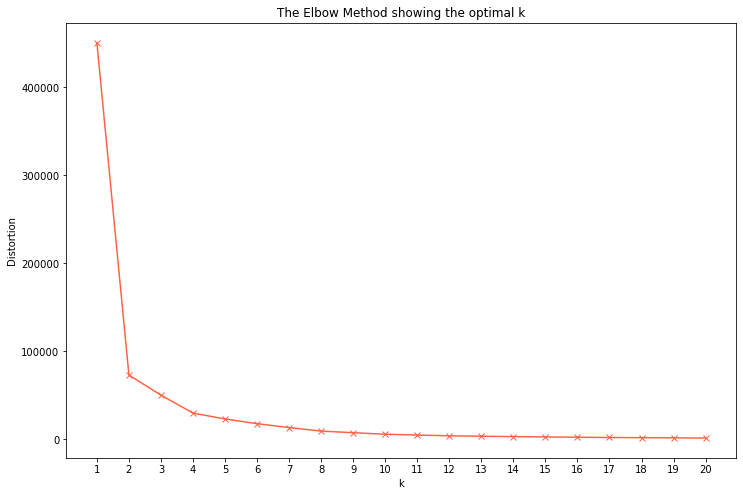

In [22]:
# perform kmeans
k_upper = 20
distortions = group_kmeans(k_upper, X)
# k=4 is the optimal k with elbow method
fig_size = (12, 8)
file_name = 'kmeans_elbow_day_i_i-2_no_norm.png'
plot_distortions(k_upper, distortions, fig_size, file_name)

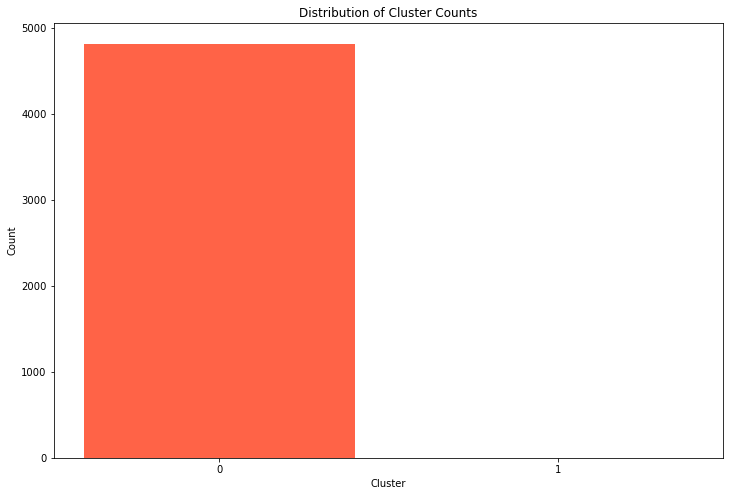

In [23]:
# perform kmeans with optimal k=4
opt_k = 2
model = single_kmeans(opt_k, X)
# plot distribution of labels
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-2_no_norm_cluster_distr.png'
plot_label_distr(model.labels_, fig_size, file_name)
# note:the clusters are very imbalanced -> maybe need a way to improve later

## Perform clustering with standardized data and plot return
* variance of volume/volume_i-1 is much larger than the rest
* it could be a good idea to standardize data before clustering

In [24]:
print(X.var())
# standarsize 
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)

open/open_i-1             0.000145
high/high_i-1             0.000092
low/low_i-1               0.000134
close/close_i-1           0.000131
volume/volume_i-1        86.095448
open_i-1/open_i-2         0.000151
high_i-1/high_i-2         0.000096
low_i-1/low_i-2           0.000144
close_i-1/close_i-2       0.000131
volume_i-1/volume_i-2     7.392679
dtype: float64


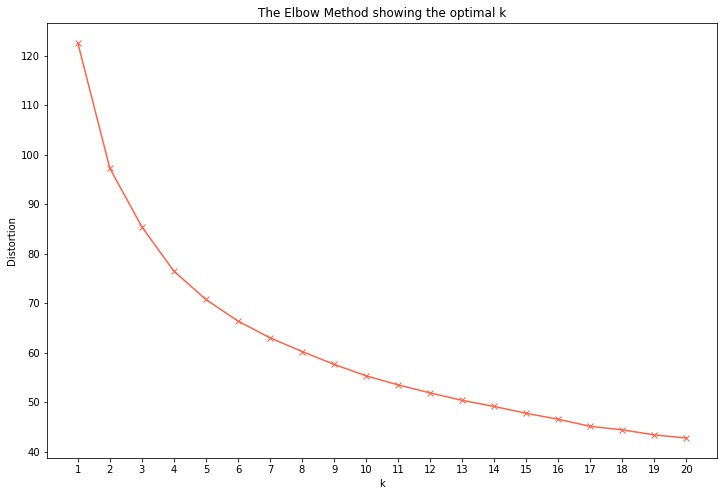

In [25]:
# perform kmeans
k_upper = 20
distortions = group_kmeans(k_upper, X_minmax)
# k=4 is the optimal k with elbow method
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-2_elbow.png'
plot_distortions(k_upper, distortions, fig_size, file_name)

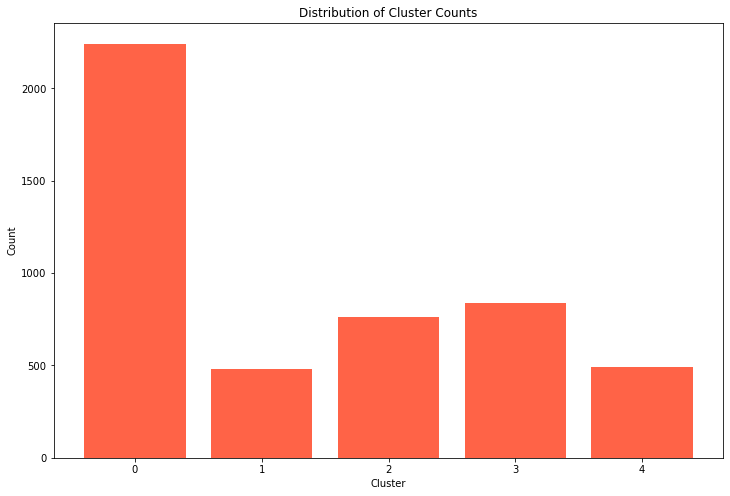

In [27]:
# perform kmeans with optimal k=4
opt_k = 5
model = single_kmeans(opt_k, X_minmax)
# plot distribution of labels
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-2_clusters.png'
plot_label_distr(model.labels_, fig_size, file_name)
# note:the clusters are still somehow imbalanced but much better

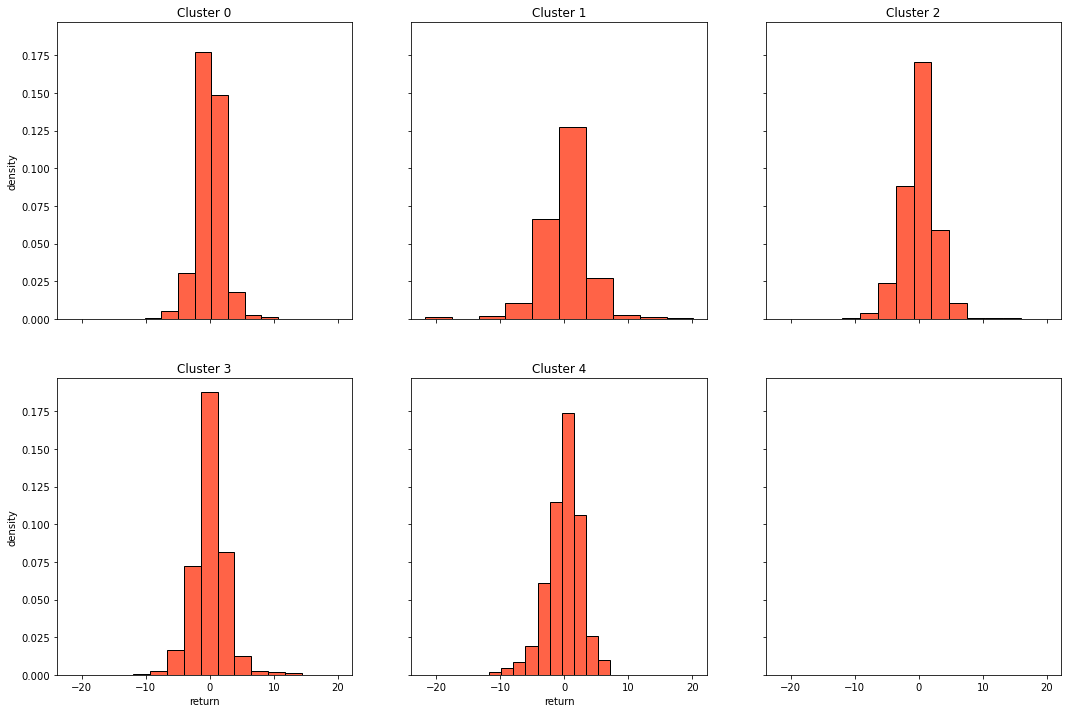

In [28]:
nrows, ncols = 2, 3
fig_size = (18, 12)
file_name = 'kmeans_day_i_i-2_returns.png'
plot_return(model.labels_, np.array(train['return_i+1']), opt_k, nrows, ncols, fig_size, file_name)

## Results analysis on train and test data

In [29]:
# report mean and variance of each cluster return: training
report_return_mean_std(opt_k, model.labels_, np.array(train['return_i+1']))

cluster0 return: mean -0.0366, std 2.037
cluster1 return: mean 0.2283, std 3.6076
cluster2 return: mean 0.0703, std 2.6961
cluster3 return: mean -0.0273, std 2.5688
cluster4 return: mean -0.0556, std 2.695


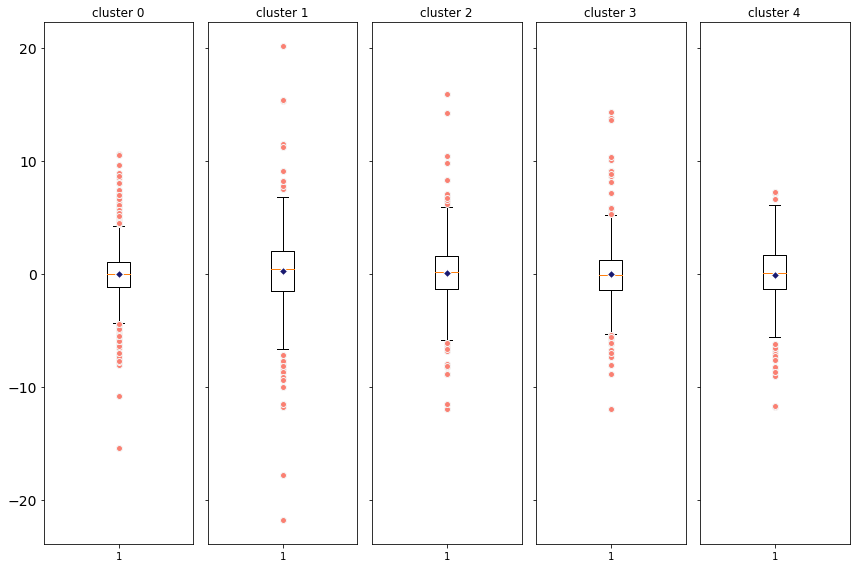

In [30]:
# box plot for training returns 
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-2_returns_boxplot.png'
plot_return_box(model.labels_, np.array(train['return_i+1']), opt_k, fig_size, file_name)

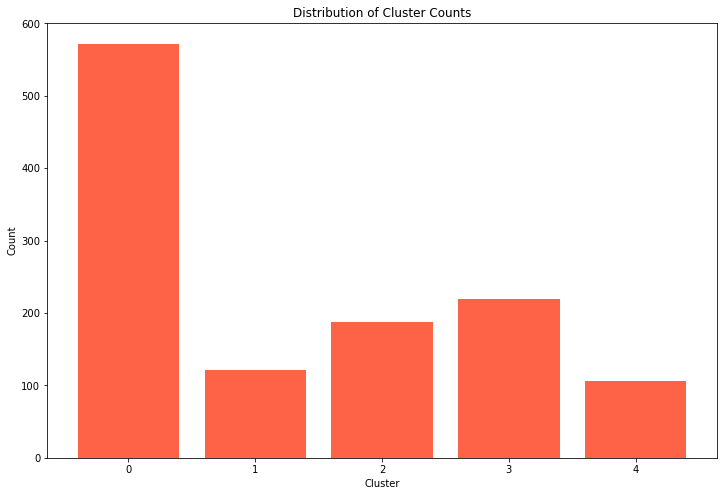

In [31]:
# predict cluster of test data and draw distribution
# standardize test_X
test_X_minmax = min_max_scaler.transform(test_X)
# predict clusters of test data
test_pred = model.predict(test_X_minmax)
# draw distribution
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-2_clusters_test.png'
plot_label_distr(test_pred, fig_size, file_name)
# very similar distribution of clusters compared to train data
# test data distr mirrors train data distr based on clusters

E:\softwares\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
E:\softwares\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
E:\softwares\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
E:\softwares\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo"

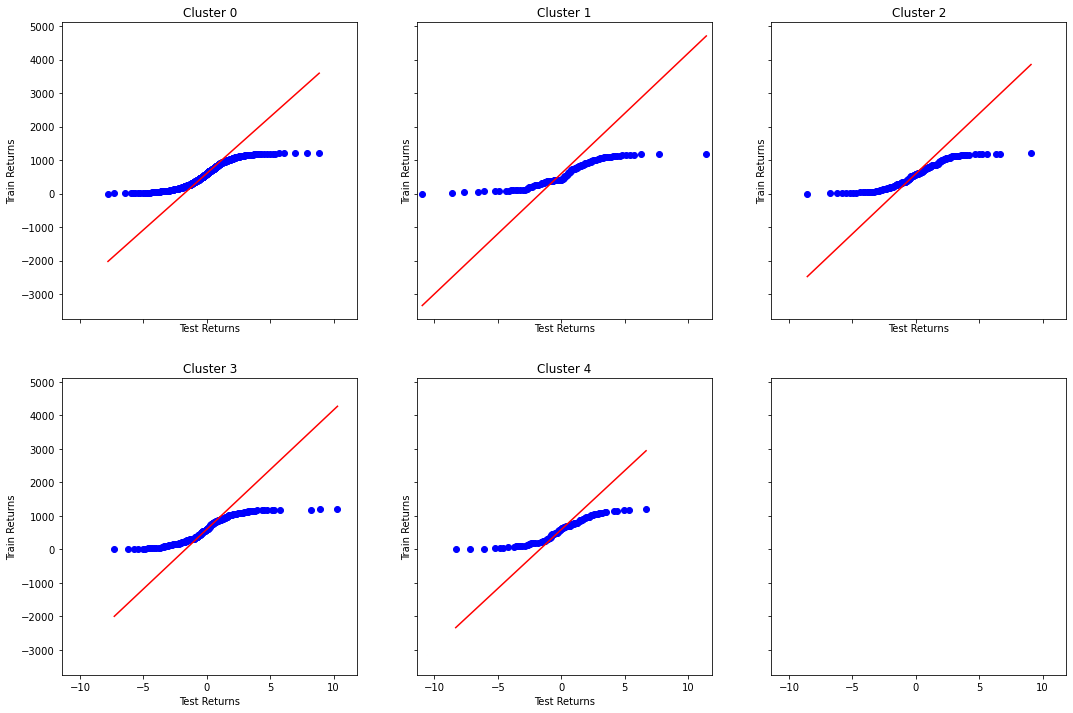

In [32]:
nrows, ncols = 2, 3
fig_size = (18, 12)
file_name = 'kmeans_day_i_i-2_qq.png'
plot_qq(model.labels_, test_pred, np.array(train['return_i+1']),
        np.array(test['return_i+1']), opt_k, nrows, ncols, fig_size, file_name)

In [33]:
# report mean and std of test returns for each cluster
report_return_mean_std(opt_k, test_pred, np.array(train['return_i+1']))

cluster0 return: mean 0.0034, std 2.4961
cluster1 return: mean -0.3178, std 2.1285
cluster2 return: mean -0.0855, std 2.6117
cluster3 return: mean 0.3192, std 2.4738
cluster4 return: mean 0.1531, std 2.506
